<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/hazel_alibinetOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/Pql6ShORpNU


<br>
Outlier detection using alibi-detect<br>
Alibi Detect is an open source Python library focused on outlier, adversarial and drift detection. <br>
The package aims to cover both online and offline detectors for tabular data, text, <br>
images and time series. The outlier detection methods should allow the user to <br>
identify global, contextual and collective outliers.<br>
pip install alibi-detect<br>
https://github.com/SeldonIO/alibi-detect<br>
Documentation: https://docs.seldon.io/_/downloads/alibi-detect/en/v0.5.1/pdf/<br>
We will be using VAE based outlier detection. Based on this paper:<br>
    https://arxiv.org/pdf/1312.6114.pdf<br>
    <br>
The Variational Auto-Encoder (VAE) outlier detector is first trained on a batch <br>
of unlabeled, but normal (inlier) data. Unsupervised training is desireable since <br>
labeled data is often scarce. The VAE detector tries to reconstruct the input it <br>
receives. If the input data cannot be reconstructed well, the reconstruction error <br>
is high and the data can be flagged as an outlier. The reconstruction error is either <br>
measured as the mean squared error (MSE) between the input and the reconstructed instance <br>
or as the probability that both the input and the reconstructed instance are <br>
generated by the same process.<br>
Data set info: https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf<br>
Data set link: https://www.mvtec.com/company/research/datasets/mvtec-ad<br>


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
!git clone https://github.com/SeldonIO/alibi-detect.git

Cloning into 'alibi-detect'...
remote: Enumerating objects: 4557, done.
remote: Counting objects: 100% (523/523), done.
remote: Compressing objects: 100% (353/353), done.
remote: Total 4557 (delta 301), reused 314 (delta 167), pack-reused 4034
Receiving objects: 100% (4557/4557), 30.49 MiB | 28.05 MiB/s, done.
Resolving deltas: 100% (2888/2888), done.


In [ ]:
!pip install alibi

     |████████████████████████████████| 398 kB 5.3 MB/s 
     |████████████████████████████████| 4.0 MB 44.3 MB/s 
     |████████████████████████████████| 28.0 MB 1.6 MB/s 
     |████████████████████████████████| 462 kB 44.9 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 6.5 MB 35.4 MB/s 
     |████████████████████████████████| 895 kB 33.0 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052158 sha256=6e5f7eda3c9298ee349085a3f09817324e4fb0b8f3fb9913193996d632f99805
  Stored in directory: /root/.cache/pip/wheels/b6/09/83/36dd0224ce32dcdf5e218b36362235ca2e50cece60a966ae1b
Successfully built spacy-lookups-data
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

In [ ]:
%cd /content/alibi-detect

/content/alibi-detect


In [ ]:
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

########################################################################<br>
oad data. We only need good data and anything NOT good is an outlier. 

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_directory = '/content/drive/MyDrive/hazel/train/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

In [ ]:
good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

In [ ]:
dataset = np.array(dataset)

In [ ]:
train = dataset[0:200]
test = dataset[200:279]

In [ ]:
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

et us also load bad images to verify our trained model. 

In [ ]:
bad_images = os.listdir(image_directory + 'bad')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.

#######################################################################<br>
efine the encoder - decoder network for input to the OutlierVAE detector class. <br>
an be any encoder and decoder. 

In [ ]:
encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

efine encoder

In [ ]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

In [ ]:
print(encoder_net.summary())
#print(encoder_net.input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None


efine the decoder. <br>
tart with the bottleneck dimension (encoder vector) and connect to dense layer <br>
ith dim = total nodes in the last conv. in the encoder. 

In [ ]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

In [ ]:
print(decoder_net.summary())
#print(decoder_net.input_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        3075      
 ranspose)                                                       
                                                      

#####################################################################<br>
efine and train the outlier detector. 

In [ ]:
latent_dim = 1024  #(Same as encoding dim. )

initialize outlier detector

In [ ]:
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

In [ ]:
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.015


train<br>
rom alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

In [ ]:
adam = tf.keras.optimizers.Adam(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
od.fit(train,
       optimizer = adam,
       epochs=1000,
       batch_size=64,
       verbose=True)

4/4 [=] - 1s 127ms/step - loss_ma: -24864.8252


heck the threshold value. Should be the same as defined before. 

In [ ]:
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.002


<br>
nfer_threshold Updates threshold by a value inferred from the percentage of <br>
nstances considered to be outliers in a sample of the dataset.<br>
ercentage of X considered to be normal based on the outlier score.<br>
ere, we set it to 99%

In [ ]:
od.infer_threshold(test, outlier_type='instance', threshold_perc=100.0)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.0026385553646832705


In [ ]:
from alibi_detect.utils.saving import save_detector, load_detector
save_detector     (od, "/content/drive/MyDrive/screwmodel/screw1.h5")
od = load_detector(    "/content/drive/MyDrive/screwmodel/screw1.h5")

save the trained outlier detector<br>
s mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7<br>
rom alibi_detect.utils import save_detector, load_detector<br>
ave_detector(od, "saved_outlier_models/carpet_od_20epochs.h5")<br>
d = load_detector(filepath)

est our model on a bad image

In [ ]:
od.threshold = 0.00211
img_num = 0
scoremaximo = 0
estanOK = 0
cantidaddefotos = 1

The instance score is: 0.0005002687
Is this image an outlier (0 for NO and 1 for YES)? 0
img num 23


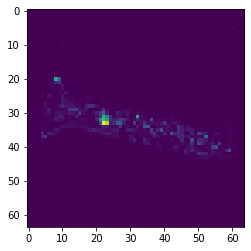

In [ ]:


for totaldefotos in range(cantidaddefotos):

    test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
    plt.imshow(test_bad_image[0])

    test_bad_image_recon = od.vae(test_bad_image)
    test_bad_image_recon = test_bad_image_recon.numpy()
    plt.imshow(test_bad_image_recon[0])

    test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

    bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
    print("The instance score is:", bad_image_instance_score)

    bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
    plt.imshow(bad_image_feature_score[:,:,0])
    print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])
    print("img num",img_num)

    img_num = img_num + 1




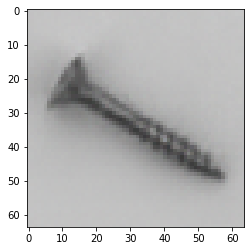

In [ ]:
test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

In [ ]:
test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

ata dictionary contains the instance_score, feature_score, and whether it is an outlier or not. <br>
et u look at the values under the 'data' key in our output dictionary

In [ ]:
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

The instance score is: 0.00094030146


Is this image an outlier (0 for NO and 1 for YES)? 0


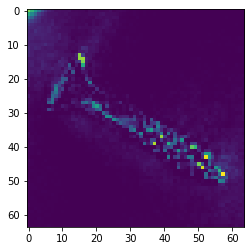

In [ ]:
bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

ou can also manually define the threshold based on your specific use case. 

In [ ]:
od.threshold = 0.002
print("Current threshld value is: ", od.threshold)

Current threshld value is:  0.002


et us check it for multiple images

In [ ]:
X = bad_dataset[:20]

In [ ]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

In [ ]:
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


catter plot of instance scores. using the built-in function for the scatterplot. 

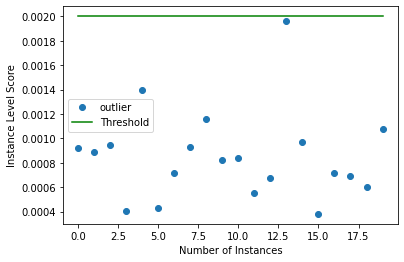

In [ ]:
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

lot features for select images, using the built in function (plot_feature_outlier_image)

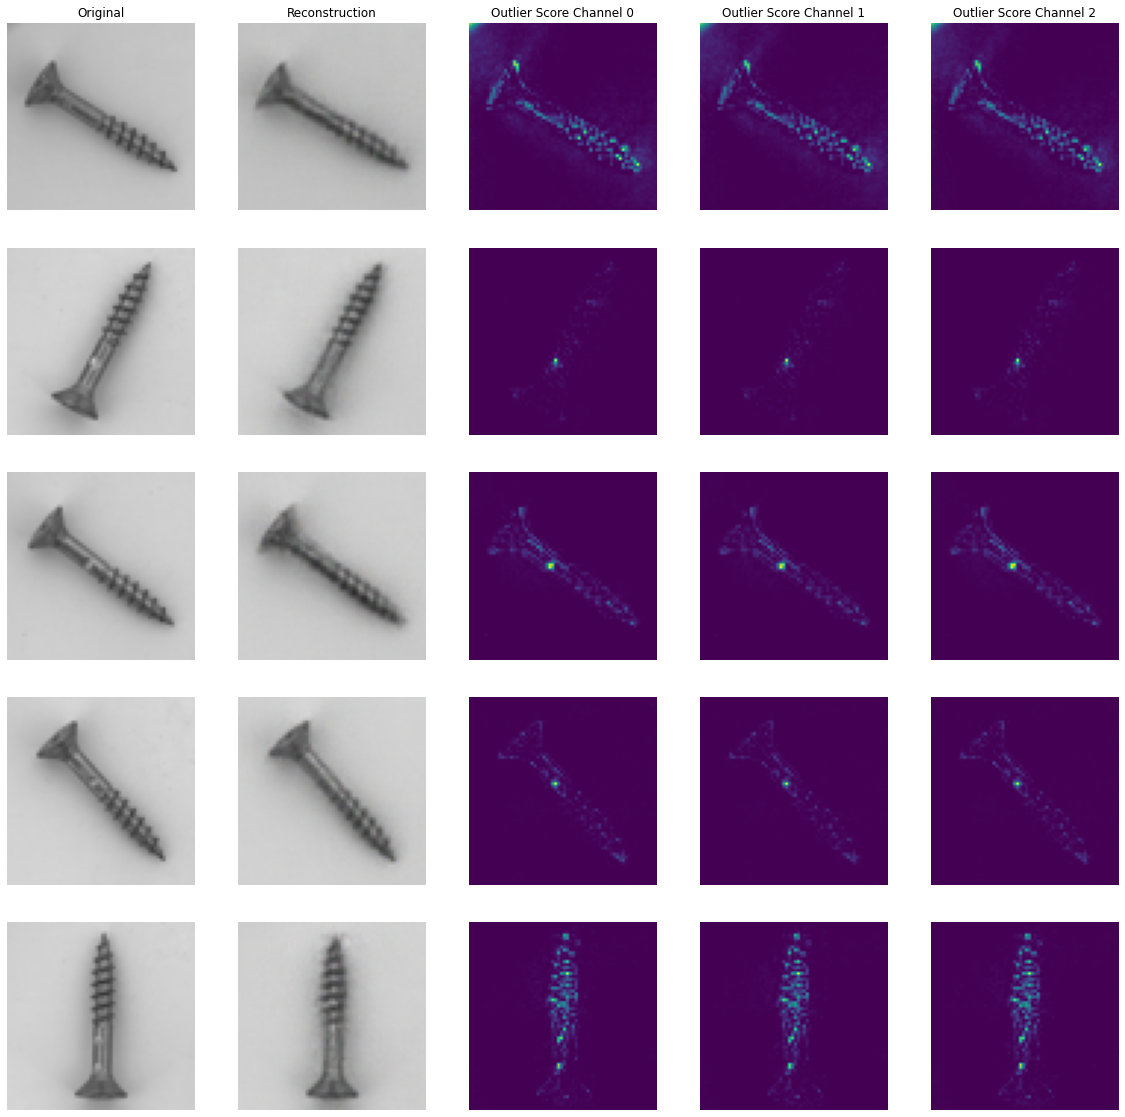

In [ ]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[0, 5, 10, 15, 17],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

#####################################